In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
def DataLoader(link, name_of_file):
  id = link.split("/")[-2]
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name_of_file)
  dataframe = pd.read_csv(name_of_file)
  return dataframe

link = 'https://drive.google.com/file/d/1A46FlopzRBsaLeq0-NawM5xRpcpxQ2I2/view?usp=sharing'
name = 'user_sensor_data.csv'
df_happimeter = DataLoader(link, name)

<ipython-input-3-10e80b370348>:10: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  df_happimeter = DataLoader(link, name)


In [ ]:
rehearsal_start_stamp = '3/9/22 17:49'
rehearsal_end_stamp = '3/9/22 19:33'

In [ ]:
def segregate(df, start_stamp, end_stamp):
  return df[(df['timestamp'] >= start_stamp) & (df['timestamp'] <= end_stamp)] 

df_rehearsal = segregate(df_happimeter, rehearsal_start_stamp, rehearsal_end_stamp)

In [ ]:
def drop(df, columns):
  return df.drop(columns, axis = 1)

df_rehearsal = drop(df_rehearsal, drop_columns)

In [ ]:
def drop_rows(df):
  index_names = df[ (df['type'] == 'LocationLat') | (df['type'] == 'LocationLon') | (df['type'] == 'LocationAlt') | (df['type'] == 'Step') | (df['type'] == 'AccelerometerMagX') | (df['type'] == 'AccelerometerMagY') | (df['type'] == 'AccelerometerMagZ') | (df['type'] == 'VMC') | (df['type'] == 'ActivityStill') | (df['type'] == 'ActivityInCar') | (df['type'] == 'ActivityUnspecific') | (df['type'] == 'ActivityOnFoot') | (df['type'] == 'ActivityWalking') | (df['type'] == 'ActivityRunning') | (df['type'] == 'ActivityOnBicycle') | (df['type'] == 'HeartrateClean') | (df['type'] == 'Microphone') ].index
  df.drop(index_names, inplace = True)
  return df

df_rehearsal = drop_rows(df_rehearsal)

In [ ]:
def timeindex(df):
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df = df.set_index('timestamp')
  return df

df_rehearsal = timeindex(df_rehearsal)

In [ ]:
df_rehearsal

,user_id,type,average
timestamp,,,
2022-03-09 17:49:00,420,AccelerometerX,-0.290018
2022-03-09 17:49:00,420,AccelerometerY,-7.811824
2022-03-09 17:49:00,420,AccelerometerZ,-5.559431
2022-03-09 17:55:00,420,AccelerometerX,-1.552444
2022-03-09 17:55:00,420,AccelerometerY,-7.680176
...,...,...,...
2022-03-09 19:25:00,2189,AccelerometerZ,-0.981384
2022-03-09 19:33:00,2189,AccelerometerX,3.620439
2022-03-09 19:33:00,2189,AccelerometerY,-8.015867


In [ ]:
df_rehearsal.user_id.unique() 

array([ 420, 2190, 2191, 2193, 2192, 2194, 2195, 2197, 2196,  787,  974,
        789,  788, 1144,  972,  894,  798,  799,  797,  796,  795, 2189])

In [ ]:
len(df_rehearsal.user_id.unique())

22

In [ ]:
def UserAugment(userid, df):
  df_user = df.loc[df['user_id'] == userid]
  df_accx = df_user.loc[df_user['type'] == "AccelerometerX"]
  df_accy = df_user.loc[df_user['type'] == "AccelerometerY"]
  df_accz = df_user.loc[df_user['type'] == "AccelerometerZ"]
  df_hr = df_user.loc[df_user['type'] == "Heartrate"]
  df_user_new = df_accx.drop(['type'], axis=1)
  df_user_new = df_user_new.rename(columns = {'average':'AccelerometerX'})
  df_user_new = df_user_new.resample('S').mean()
  df_user_new = df_user_new.interpolate(method ='polynomial', order=3)
  df_accy = df_accy.resample('S').mean()
  df_accy = df_accy.interpolate(method ='polynomial', order=3)
  df_accz = df_accz.resample('S').mean()
  df_accz = df_accz.interpolate(method ='polynomial', order=3)
  df_hr = df_hr.resample('S').mean()
  df_hr = df_hr.interpolate(method ='polynomial', order=3)
  accelerometery = df_accy['average']
  accelerometerz = df_accz['average']
  heartrate = df_hr['average']
  df_user_new['AccelerometerY'] = accelerometery
  df_user_new['AccelerometerZ'] = accelerometerz
  df_user_new['HeartRate'] = heartrate
  return df_user_new

In [ ]:
def AugmentUser(userid, dfproc):
  df_final = dfproc.assign(Movement=lambda x: np.sqrt(x['AccelerometerX'] ** 2 + x['AccelerometerY'] ** 2 + x['AccelerometerZ'] ** 2))
  df_final = df_final.drop(['AccelerometerX', 'AccelerometerY', 'AccelerometerZ'], axis=1)
  df_final['user_id'] = userid
  return df_final

In [ ]:
df_2190_augment = UserAugment(2190, df_rehearsal)
df_augment_2190 = AugmentUser(2190, df_2190_augment)

In [ ]:
df_augment_2190

,user_id,HeartRate,Movement
timestamp,,,
2022-03-09 17:49:00,2190,75.951389,8.338047
2022-03-09 17:49:01,2190,77.188046,8.339104
2022-03-09 17:49:02,2190,78.404818,8.341782
2022-03-09 17:49:03,2190,79.601828,8.346005
2022-03-09 17:49:04,2190,80.779196,8.351695
...,...,...,...
2022-03-09 19:32:56,2190,83.547344,9.158860
2022-03-09 19:32:57,2190,83.251900,9.264597
2022-03-09 19:32:58,2190,82.951312,9.376648


In [ ]:
def getFlow(userid, maindf):
  df_user_augment = UserAugment(userid, maindf)
  df_augment_user = AugmentUser(userid, df_user_augment)
  df_user_per_min = df_augment_user.resample('300S').mean()
  df_5_min = df_user_per_min
  df_1_min = df_5_min.resample('S').mean()
  df_1_min = df_1_min.interpolate(method ='polynomial', order=3)
  df_1_min["Flow"] = df_1_min["Movement"].diff()
  df_1_min['Flow'] = df_1_min['Flow'].abs()
  return df_1_min

##Flow of Jazz Musicians

Segregation of Jazz Musicians 

*   420 - Audience
*   2190 - Drums
*   2191 - Trumpet
*   2193 - Audience
*   2192 - Clarinet
*   2194 - Vocals
*   2195 - Conductor
*   2197 - Audience
*   2196 - Drums
*   787 - Drums 
*   974 - Saxophone
*   789 -  Saxophone
*   788 - Bass 
*   1144 - Saxophone
*   972 - Piano
*   894 - Vocals 
*   798 - Vocals
*   799 - Keyboard
*   797 - Saxophone
*   796 - Saxophone (star)
*   795 - Saxophone
*   2189 - Saxophone (star)


In [ ]:
df_420 = getFlow(420, df_rehearsal)
df_2190 = getFlow(2190, df_rehearsal)
df_2191 = getFlow(2191, df_rehearsal)
df_2193 = getFlow(2193, df_rehearsal)
df_2192 = getFlow(2192, df_rehearsal)
df_2194 = getFlow(2194, df_rehearsal)
df_2195 = getFlow(2195, df_rehearsal)
df_2197 = getFlow(2197, df_rehearsal)
df_2196 = getFlow(2196, df_rehearsal)
df_787 = getFlow(787, df_rehearsal)
df_974 = getFlow(974, df_rehearsal)
df_789 = getFlow(789, df_rehearsal)
df_788 = getFlow(788, df_rehearsal)
df_1144 = getFlow(1144, df_rehearsal)
df_972 = getFlow(972, df_rehearsal)
df_894 = getFlow(894, df_rehearsal)
df_798 = getFlow(798, df_rehearsal)
df_799 = getFlow(799, df_rehearsal)
df_797= getFlow(797, df_rehearsal)
df_796 = getFlow(796, df_rehearsal)
df_795 = getFlow(795, df_rehearsal)
df_2189 = getFlow(2189, df_rehearsal)

In [ ]:
df_1144

,user_id,HeartRate,Movement,Flow
timestamp,,,,
2022-03-09 17:45:00,1144.0,64.042925,9.323326,NaN
2022-03-09 17:45:01,1144.0,64.196148,9.312226,0.011100
2022-03-09 17:45:02,1144.0,64.348518,9.301201,0.011025
2022-03-09 17:45:03,1144.0,64.500039,9.290250,0.010951
2022-03-09 17:45:04,1144.0,64.650712,9.279374,0.010876
...,...,...,...,...
2022-03-09 19:29:56,1144.0,72.954209,8.550053,0.004798
2022-03-09 19:29:57,1144.0,73.000072,8.554874,0.004821
2022-03-09 19:29:58,1144.0,73.046145,8.559718,0.004844


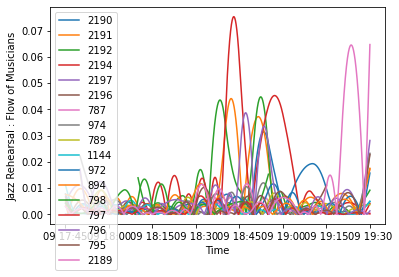

In [ ]:
# sns.lineplot(x="timestamp", y="Flow", data=df_420, label = "420")
sns.lineplot(x="timestamp", y="Flow", data=df_2190, label = "2190")
sns.lineplot(x="timestamp", y="Flow", data=df_2191, label = "2191")
# sns.lineplot(x="timestamp", y="Flow", data=df_2193, label = "2193")
sns.lineplot(x="timestamp", y="Flow", data=df_2192, label = "2192")
sns.lineplot(x="timestamp", y="Flow", data=df_2194, label = "2194")
# sns.lineplot(x="timestamp", y="Flow", data=df_2195, label = "2195")
sns.lineplot(x="timestamp", y="Flow", data=df_2197, label = "2197")
sns.lineplot(x="timestamp", y="Flow", data=df_2196, label = "2196")
sns.lineplot(x="timestamp", y="Flow", data=df_787, label = "787")
sns.lineplot(x="timestamp", y="Flow", data=df_974, label = "974")
sns.lineplot(x="timestamp", y="Flow", data=df_789, label = "789")
# sns.lineplot(x="timestamp", y="Flow", data=df_788, label = "788")
sns.lineplot(x="timestamp", y="Flow", data=df_1144, label = "1144")
sns.lineplot(x="timestamp", y="Flow", data=df_972, label = "972")
sns.lineplot(x="timestamp", y="Flow", data=df_894, label = "894")
sns.lineplot(x="timestamp", y="Flow", data=df_798, label = "798")
# sns.lineplot(x="timestamp", y="Flow", data=df_799, label = "799")
sns.lineplot(x="timestamp", y="Flow", data=df_797, label = "797")
sns.lineplot(x="timestamp", y="Flow", data=df_796, label = "796")
sns.lineplot(x="timestamp", y="Flow", data=df_795, label = "795")
sns.lineplot(x="timestamp", y="Flow", data=df_2189, label = "2189")
plt.ylabel("Jazz Rehearsal : Flow of Musicians")
plt.xlabel("Time")
plt.show()